In [1]:
using Flux, JLD2, Random, MLUtils, Plots, DSP, ProgressMeter, Statistics, Zygote, LinearAlgebra

In [2]:
function partial_nenc(d)
N = Zygote.jacobian(NN.nenc, d)
n = NN.nenc(d)
c = sencb(d)
M = Zygote.jacobian(n) do nn
    NN.dec(cat(c, nn, dims = 1))
end
return M[1]*N[1]
end

partial_nenc (generic function with 1 method)

In [3]:

function partial_nenc(d0, d)
N = Zygote.jacobian(NN.nenc, d)
n = NN.nenc(d)
c = sencb(d0)
M = Zygote.jacobian(n) do nn
    NN.dec(cat(c, nn, dims = 1))
end
return M[1]*N[1]
end

partial_nenc (generic function with 2 methods)

In [4]:
function partial_senc(d)
N = Zygote.jacobian(sencb, d)
n = NN.nenc(d)
c = sencb(d)
M = Zygote.jacobian(c) do cc
    NN.dec(cat(cc, n, dims = 1))
end
return M[1]*N[1]
end

partial_senc (generic function with 1 method)

In [5]:
function norm_partial_senc(d)
mapreduce(+, eachslice(d, dims=2)) do dd
B = partial_senc(dd)
return norm(B, 2)/sqrt(length(dd))
end
end
function norm_partial_nenc(d)
mapreduce(+, eachslice(d, dims=2)) do dd
B = partial_nenc(dd)
return norm(B, 2)/sqrt(length(dd))
end
end

norm_partial_nenc (generic function with 1 method)

In [6]:
gr()

Plots.GRBackend()

In [7]:
include("symae.jl")

In [8]:
xpu = gpu

gpu (generic function with 4 methods)

In [9]:
# 
function toy_green!(x, pos_rand_flag=false, len_rand_flag=false)
    nt = size(x, 1)
    nr = size(x, 2)
    for ir = 1:nr
    if(pos_rand_flag)
        it0=randobs(0:nt-20)
        # it0=randobs([25, 50, 40, 100, 120])
    else
        it0=0
    end
    if(len_rand_flag)
        # len = randobs([3, 20])
        len = randobs([1, 3])
    else
        len = 20
    end

        for it in 1+it0:len+it0
            x[it, ir] = randn()
        end
        x[:, ir] .= x[:, ir] .- mean(x[:, ir])
    end
    return x
end

toy_green! (generic function with 3 methods)

nsamp_train = 3000 = 3000
nsamp_test = 100 = 100


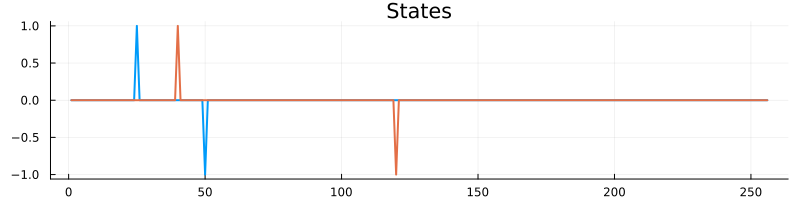

In [10]:
## 
ntc = 200
nt = 256
@show nsamp_train = 3000
@show nsamp_test = 100
##

## ╔═╡ 477b038d-5a40-4af8-91b8-b81e52a1c5fd
mp(x, s = "") = plot(cpu(x), size = (800, 200), label = nothing, w = 2, title = s)
##

##
g1 = zeros(nt, nsamp_train)
toy_green!(g1)
g1train, g1test = splitobs(g1, at = 0.9)
g2 = zeros(nt, nsamp_train)
toy_green!(g2)
g2train, g2test = splitobs(g2, at = 0.9)
# gnew = zeros(nt, nsamp_test)
# toy_green!(gnew, true)
mp(randobs(g1, 10), "randomly picked filters")
##

##
function multiconv(g, s)
    g = cat(g, dims = 3)
    g = permutedims(g, [1, 3, 2])
    s = cat(s, dims = 3)
    # s=permutedims(s,[1,3,2]); 
    d = Flux.conv(g, s, groups = size(g, 2), pad = size(s, 1), flipped = false)
    d = permutedims(d, [1, 3, 2])
    d = dropdims(d, dims = 3)
    return Float32.(d[2:size(g, 1)+1, :])
end
##

##
s1 = zeros(nt)
s1[25] = 1.0; s1[50]=-1.0
s2 = zeros(nt)
s2[25] = 1.0; s2[100]=-1.0
s2 = zeros(nt)
s2[40] = 1.0; s2[120]=-1.0
# generate sources
# s1=randn(nts)
# s1 = DSP.Windows.triang(10)
# s1 = randn(10)
# s1 = Flux.normalise(s1)
# s1=Flux.normalise(s1)
# s2=randn(nts)
# s2 = DSP.Windows.hanning(20)
# s2 = randn(20)
# s2 = Flux.normalise(s2)
# s3 = Flux.normalise(s2)
snew = randn(10)
mp([s1, s2], "States")
##

In [11]:
function get_random_source()
    return randn(10)
end

get_random_source (generic function with 1 method)

In [12]:
##
d1 = multiconv(g1train, s1) |> xpu
d2 = multiconv(g2train, s2) |> xpu
d12 = multiconv(g2train, s1)
d21 = multiconv(g1train, s2)

dnew=zero(cpu(d1))
toy_green!(dnew, true, true)
dnew= gpu(dnew)
# dnew = multiconv(gnew, snew) |> xpu

d1 = Flux.normalise(d1, dims = 1)
d2 = Flux.normalise(d2, dims = 1)
d12 = Flux.normalise(d12, dims = 1)
d21 = Flux.normalise(d21, dims = 1)
dnew = Flux.normalise(dnew, dims = 1)

d1test = multiconv(g1test, s1) |> xpu
d2test = multiconv(g2test, s2) |> xpu
d1test = Flux.normalise(d1test, dims = 1)
d2test = Flux.normalise(d2test, dims = 1);

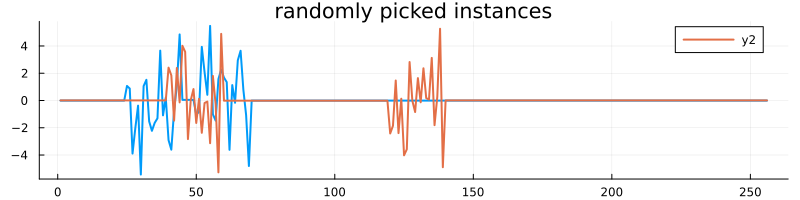

In [13]:
mp(cpu(randobs(d1)), "randomly picked instances")
plot!(cpu(randobs(d2)), w = 2)

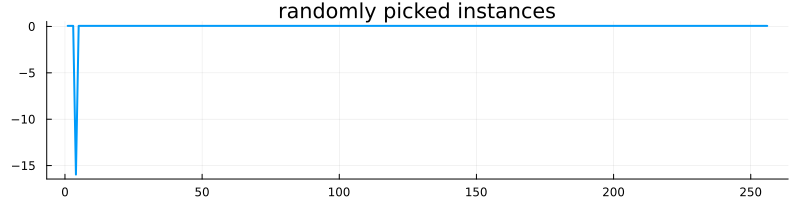

In [14]:
mp(cpu(randobs(dnew)), "randomly picked instances")

# Initialize Networks

In [15]:
begin
    @show p = 100
    @show q1 = 30
    @show q2 = 30
end

begin
    opt = ADAM(0.001)
    nepoch = 100
    trainloss = []
    testloss = []
    norm_partial_nenc_buffer = []
    norm_partial_senc_buffer = []
    # X = get_data_iterator([d1, d2, dnew])
    X = get_data_iterator([d1, d2])
    nothing
end

##

E = reshape(diagm(ones(Float32, nt)), nt, nt, 1, 1) |> xpu

# senc1, senc2, nenc, dec = get_dense_networks(nt, p, q)
NN = get_dense_networks_new(nt, p, q1, q2)
sencb = BroadcastSenc(NN.senc1, NN.senc2)
nencb = BroadcastNenc_new(NN.nenc1, NN.nenc2, E)
decb = BroadcastDec(NN.dec)
encb = JoinEncs(sencb, nencb)
model(x) = decb(encb(x))
##

p = 100 = 100
q1 = 30 = 30
q2 = 30 = 30


model (generic function with 1 method)

In [24]:
begin
    @show p = 100
    @show q = 30
end

begin
    opt = ADAM(0.001)
    nepoch = 100
    trainloss = []
    testloss = []
    norm_partial_nenc_buffer = []
    norm_partial_senc_buffer = []
    # X = get_data_iterator([d1, d2, dnew])
    X = get_data_iterator([d1, d2])
    nothing
end

##

# senc1, senc2, nenc, dec = get_dense_networks(nt, p, q)
NN = get_dense_networks(nt, p, q)
sencb = BroadcastSenc(NN.senc1, NN.senc2)
nencb = BroadcastNenc(NN.nenc)
decb = BroadcastDec(NN.dec)
encb = JoinEncs(sencb, nencb)
model(x) = decb(encb(x))
##

p = 100 = 100
q = 30 = 30


model (generic function with 1 method)

In [16]:
NN

(senc1 = Chain(Dense(256 => 242, elu), Dense(242 => 228, elu), Dense(228 => 214, elu), Dense(214 => 200)), senc2 = Chain(Dense(200 => 200, elu), Dense(200 => 100)), nenc1 = Chain(Dense(256 => 199, elu), Dense(199 => 143, elu), Dense(143 => 86, elu), Dense(86 => 30)), nenc2 = Chain(Dense(7680 => 5767, elu), Dense(5767 => 3855, elu), Dense(3855 => 1942, elu), Dense(1942 => 30), Dropout(0.5, dims=(1, 2, 3))), dec = Chain(Dense(130 => 161, elu), Dense(161 => 193, elu), Dense(193 => 224, elu), Dense(224 => 256)))

In [17]:
# ╔═╡ 9a90ca61-aafb-4ee9-9570-db15991fe46d
function update_losses(trainloss, testloss, NN)
    NN = map(x->Flux.trainmode!(x, false), NN)
    NN = map(x->Flux.testmode!(x, true), NN)
    dd1 = randobs(d1, 20)
    dd2 = randobs(d2, 20)
    l1 = Flux.mse(cat(model(dd1), model(dd2), dims = 2), cat(dd1, dd2, dims = 2))
    l2 =
        Flux.mse(cat(model(d1test), model(d2test), dims = 2), cat(d1test, d2test, dims = 2))
# push!(norm_partial_senc_buffer, norm_partial_senc(randobs(d1, 1)))
# push!(norm_partial_nenc_buffer, norm_partial_nenc(randobs(d1, 1)))
    push!(trainloss, l1)
    push!(testloss, l2)
    return l1, l2
end

update_losses (generic function with 1 method)

In [18]:
# ╔═╡ c962835e-ed84-4ff3-8304-f638d656eb91
function update(nepoch, NN)
    p = Progress(nepoch, showspeed = true)
    ps = Flux.params(values(NN)...)
for epoch = 1:nepoch
        NN = map(x->Flux.trainmode!(x, true), NN)
        NN = map(x->Flux.testmode!(x, false), NN)
        for x in X
            gs = Flux.gradient(() -> Flux.mse(model(x), x), ps) # compute gradient
            Flux.Optimise.update!(opt, ps, gs) # update parameters
        end
        NN = map(x->Flux.trainmode!(x, false), NN)
        NN = map(x->Flux.testmode!(x, true), NN)
        # ltrain, ltest = update_losses(trainloss, testloss, NN)
        # ProgressMeter.next!(
        #     p;
        #     showvalues = [(:epoch, epoch), (:train_loss, ltrain), (:test_loss, ltest)],
        # )
    end
    return NN
end

update (generic function with 1 method)

# Traning

In [59]:
NN = update(50, NN)

(senc1 = Chain(Dense(256 => 242, elu), Dense(242 => 228, elu), Dense(228 => 214, elu), Dense(214 => 200)), senc2 = Chain(Dense(200 => 200, elu), Dense(200 => 100)), nenc1 = Chain(Dense(256 => 199, elu), Dense(199 => 143, elu), Dense(143 => 86, elu), Dense(86 => 30)), nenc2 = Chain(Dense(7680 => 5767, elu), Dense(5767 => 3855, elu), Dense(3855 => 1942, elu), Dense(1942 => 30), Dropout(0.5, dims=(1, 2, 3), active=false)), dec = Chain(Dense(130 => 161, elu), Dense(161 => 193, elu), Dense(193 => 224, elu), Dense(224 => 256)))

┌ Warning: No strict ticks found
└ @ PlotUtils /math/home/pawbz/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /math/home/pawbz/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /math/home/pawbz/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /math/home/pawbz/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191


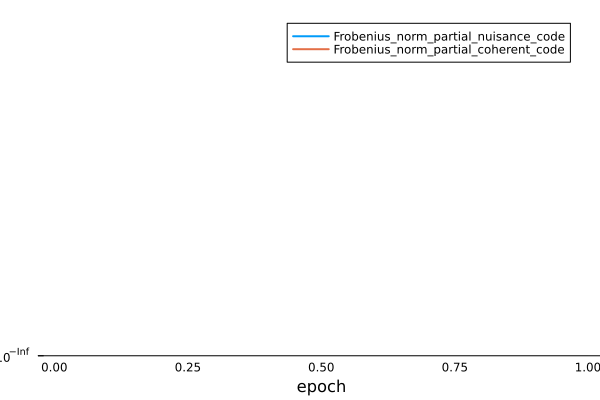

┌ Warning: No strict ticks found
└ @ PlotUtils /math/home/pawbz/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /math/home/pawbz/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /math/home/pawbz/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191


In [60]:
plot(norm_partial_nenc_buffer, yaxis = :log, label = "Frobenius_norm_partial_nuisance_code", w=2, xlabel="epoch")
plot!(norm_partial_senc_buffer, yaxis = :log, label = "Frobenius_norm_partial_coherent_code", w=2)

┌ Warning: No strict ticks found
└ @ PlotUtils /math/home/pawbz/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /math/home/pawbz/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /math/home/pawbz/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /math/home/pawbz/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191


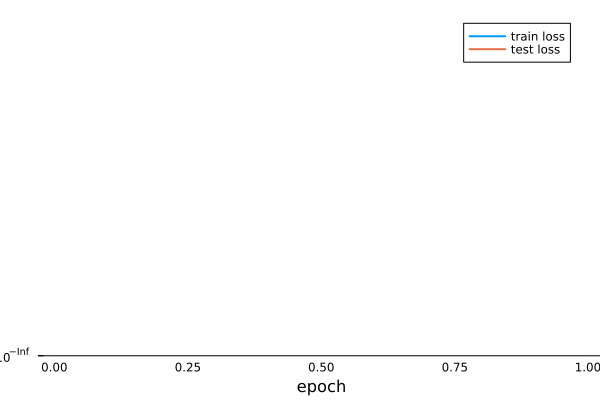

┌ Warning: No strict ticks found
└ @ PlotUtils /math/home/pawbz/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /math/home/pawbz/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /math/home/pawbz/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191


In [61]:
plot(trainloss, yaxis = :log, w=2, label = "train loss", xlabel="epoch")
plot!(testloss, yaxis = :log, w=2, label = "test loss")

In [62]:

# ╔═╡ 41fda66b-611a-458f-82d3-5a491c12afa4
begin
    NN=map(x->Flux.trainmode!(x, false), NN)
    NN=map(x->Flux.testmode!(x, true), NN)
    zsym1 = sencb(d1)
    zsym2 = sencb(d2)
    zsym_new = sencb(dnew)
    d1hat = model(d1)
    d2hat = model(d2)
    dnewhat = model(dnew)
    d1testhat = model(d1test)
    d12hat = decb(cat(zsym1, nencb(d2), dims = 1))
    d12hat = Flux.normalise(d12hat, dims=1)
    d1newhat = decb(cat(zsym1, nencb(dnew), dims = 1))
    d1newhat = Flux.normalise(d1newhat, dims=1)
    d2newhat = decb(cat(zsym2, nencb(dnew), dims = 1))
    d2newhat = Flux.normalise(d2newhat, dims=1)
    d21hat = decb(cat(zsym2, nencb(d1), dims = 1))
    d21hat = Flux.normalise(d21hat, dims=1)
    nothing
end


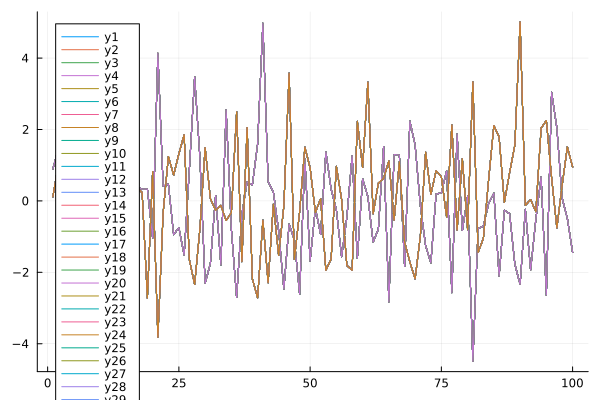

In [63]:

begin
    plot(cpu(sencb(d2))[:,1:100,1])
    plot!(cpu(sencb(d1))[:,1:100,1])
end


In [64]:
iplt2=2150

2150

In [65]:
randn

randn (generic function with 32 methods)

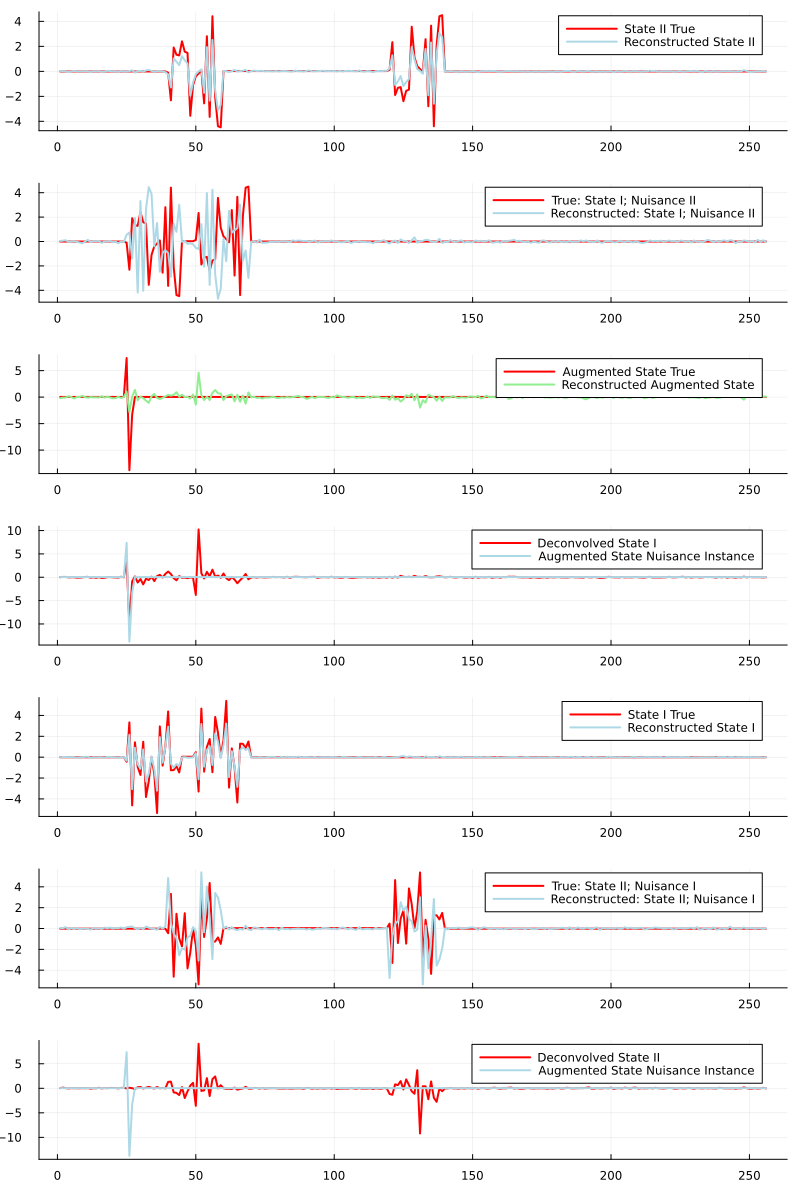

In [75]:
iplt2 = randobs(1:numobs(d1))
begin
    p1=plot(cpu(d2[:, iplt2]), c=:red, label = "State II True", )
    plot!(p1, cpu(d2hat[:, iplt2]), c=:lightblue,label = "Reconstructed State II")
    p2=plot(cpu(d12[:, iplt2]), c=:red,label = "True: State I; Nuisance II",)
    plot!(p2,cpu(d12hat[:, iplt2]), c=:lightblue,label = "Reconstructed: State I; Nuisance II")
    p3=plot(cpu(dnew[:, iplt2]), c=:red, label = "Augmented State True", )
    plot!(p3, cpu(dnewhat[:, iplt2]), c=:lightgreen,label = "Reconstructed Augmented State")
    p4=plot(cpu(d1newhat[:, iplt2]), c=:red, label = "Deconvolved State I",)
    plot!(p4,cpu(dnew[:, iplt2]), c=:lightblue,label = "Augmented State Nuisance Instance")

    p5=plot(cpu(d1[:, iplt2]), c=:red, label = "State I True", )
    plot!(p5, cpu(d1hat[:, iplt2]), c=:lightblue, label = "Reconstructed State I")
    p6=plot(cpu(d21[:, iplt2]), c=:red, label = "True: State II; Nuisance I")
    plot!(p6,cpu(d21hat[:, iplt2]), c=:lightblue, label = "Reconstructed: State II; Nuisance I")
    p7=plot(cpu(d2newhat[:, iplt2]), c=:red, label = "Deconvolved State II")
    # plot!(p2,cpu(d21hat[:, iplt2]), c=:lightblue, label = "hatx_ji")
    plot!(p7,cpu(dnew[:, iplt2]), c=:lightblue,label = "Augmented State Nuisance Instance")
    plot(p1, p2, p3, p4, p5, p6, p7, layout=(7,1), size = (800, 1200), w=2)
end

In [659]:
# iplt3=529

In [154]:
# iplt3 = randobs(1:numobs(d1))
begin
    p1=plot(cpu(d2[:, iplt3]), c=:red, label = "State II True", )
    plot!(p1, cpu(d2hat[:, iplt3]), c=:lightblue,label = "Reconstructed State II")
    p2=plot(cpu(d12[:, iplt3]), c=:red,label = "True: State I; Nuisance II",)
    plot!(p2,cpu(d12hat[:, iplt3]), c=:lightblue,label = "Reconstructed: State I; Nuisance II")
    p3=plot(cpu(dnew[:, iplt3]), c=:red, label = "Augmented State True", )
    plot!(p3, cpu(dnewhat[:, iplt3]), c=:lightgreen,label = "Reconstructed Augmented State")
    p4=plot(cpu(d1newhat[:, iplt3]), c=:red, label = "Deconvolved State I",)
    plot!(p4,cpu(dnew[:, iplt3]), c=:lightblue,label = "Augmented State Nuisance Instance")

    p5=plot(cpu(d1[:, iplt3]), c=:red, label = "State I True", )
    plot!(p5, cpu(d1hat[:, iplt3]), c=:lightblue, label = "Reconstructed State I")
    p6=plot(cpu(d21[:, iplt3]), c=:red, label = "True: State II; Nuisance I")
    plot!(p6,cpu(d21hat[:, iplt3]), c=:lightblue, label = "Reconstructed: State II; Nuisance I")
    p7=plot(cpu(d2newhat[:, iplt3]), c=:red, label = "Deconvolved State II")
    # plot!(p2,cpu(d21hat[:, iplt3]), c=:lightblue, label = "hatx_ji")
    plot!(p7,cpu(dnew[:, iplt3]), c=:lightblue,label = "Augmented State Nuisance Instance")
    plot(p1, p2, p3, p4, p5, p6, p7, layout=(7,1), size = (800, 1200), w=2)
end

UndefVarError: UndefVarError: `iplt3` not defined

In [155]:
ii =  randobs(1:numobs(dnew))
@show ideal_nuisance_func(d1x0, dnew[:,ii])
plot(cpu(dnew[:, ii]))
plot!(cpu(d1x0))

UndefVarError: UndefVarError: `d1x0` not defined

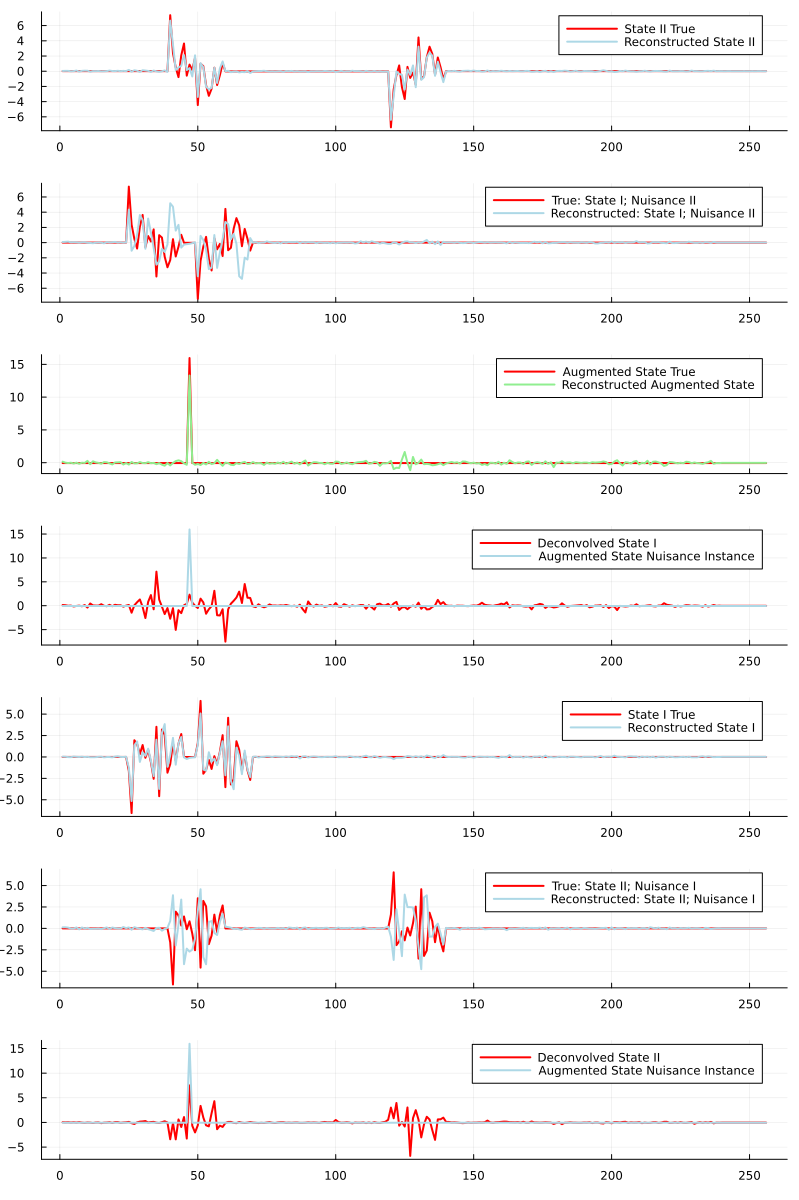

In [627]:
iplt3 = ii
begin
    p1=plot(cpu(d2[:, iplt3]), c=:red, label = "State II True", )
    plot!(p1, cpu(d2hat[:, iplt3]), c=:lightblue,label = "Reconstructed State II")
    p2=plot(cpu(d12[:, iplt3]), c=:red,label = "True: State I; Nuisance II",)
    plot!(p2,cpu(d12hat[:, iplt3]), c=:lightblue,label = "Reconstructed: State I; Nuisance II")
    p3=plot(cpu(dnew[:, iplt3]), c=:red, label = "Augmented State True", )
    plot!(p3, cpu(dnewhat[:, iplt3]), c=:lightgreen,label = "Reconstructed Augmented State")
    p4=plot(cpu(d1newhat[:, iplt3]), c=:red, label = "Deconvolved State I",)
    plot!(p4,cpu(dnew[:, iplt3]), c=:lightblue,label = "Augmented State Nuisance Instance")

    p5=plot(cpu(d1[:, iplt3]), c=:red, label = "State I True", )
    plot!(p5, cpu(d1hat[:, iplt3]), c=:lightblue, label = "Reconstructed State I")
    p6=plot(cpu(d21[:, iplt3]), c=:red, label = "True: State II; Nuisance I")
    plot!(p6,cpu(d21hat[:, iplt3]), c=:lightblue, label = "Reconstructed: State II; Nuisance I")
    p7=plot(cpu(d2newhat[:, iplt3]), c=:red, label = "Deconvolved State II")
    # plot!(p2,cpu(d21hat[:, iplt3]), c=:lightblue, label = "hatx_ji")
    plot!(p7,cpu(dnew[:, iplt3]), c=:lightblue,label = "Augmented State Nuisance Instance")
    plot(p1, p2, p3, p4, p5, p6, p7, layout=(7,1), size = (800, 1200), w=2)
end

In [157]:

begin
    plot(mp(d1test[:, iplt3]), title = "test reconstruction")
    plot!(cpu(d1testhat[:, iplt3]))
    # plot!(cpu(d12hat[:, iplt]))
end

plot(
    cpu(sencb(randobs(X)))[:, 1, :],
    label = nothing,
    w = 2,
    size = (800, 200),
    title = "coherent code d1",
)

ERROR: Out-of-bounds array access.
ERROR: Out-of-bounds array access.
ERROR: Out-of-bounds array access.
ERROR: Out-of-bounds array access.
ERROR: Out-of-bounds array access.
ERROR: Out-of-bounds array access.
ERROR: Out-of-bounds array access.
ERROR: Out-of-bounds array access.
ERROR: Out-of-bounds array access.
ERROR: Out-of-bounds array access.
ERROR: Out-of-bounds array access.
ERROR: Out-of-bounds array access.
ERROR: Out-of-bounds array access.
ERROR: Out-of-bounds array access.
ERROR: Out-of-bounds array access.
ERROR: Out-of-bounds array access.
ERROR: Out-of-bounds array access.
ERROR: Out-of-bounds array access.
ERROR: Out-of-bounds array access.
ERROR: Out-of-bounds array access.
ERROR: Out-of-bounds array access.
ERROR: Out-of-bounds array access.
ERROR: Out-of-bounds array access.
ERROR: Out-of-bounds array access.
ERROR: Out-of-bounds array access.
ERROR: Out-of-bounds array access.
ERROR: Out-of-bounds array access.
ERROR: Out-of-bounds array access.
ERROR: Out-of-bounds

CUDA.KernelException: KernelException: exception thrown during kernel execution on device NVIDIA RTX A4000

In [158]:
function ideal_nuisance_func(d0, d)
    A=partial_nenc(d0, d)
    return norm(A, 2)
end

ideal_nuisance_func (generic function with 1 method)

In [159]:
ii =  randobs(1:numobs(d1))
@show ideal_nuisance_func(d1[:,ii])
plot(cpu(d1[:, ii]))

MethodError: MethodError: no method matching ideal_nuisance_func(::CUDA.CuArray{Float32, 1, CUDA.Mem.DeviceBuffer})

Closest candidates are:
  ideal_nuisance_func(::Any, !Matched::Any)
   @ Main ~/SymAE/decon/BD.ipynb:1


In [160]:
using ForwardDiff

In [161]:
    ps = Flux.params(d1x)
    for epoch = 1:nepoch
            gs = Flux.gradient(() -> ideal_nuisance_func(d1x), ps) # compute gradient
            # Flux.Optimise.update!(opt, ps, gs) # update parameters
        end

UndefVarError: UndefVarError: `d1x` not defined

In [162]:
nepoch

100

In [163]:
using CUDA

In [164]:
d1x=randobs(dnew) |> xpu;
d1x_initial = copy(d1x)

256-element CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}:
 -0.087991215
 -0.087991215
 -0.087991215
 -0.087991215
 -0.087991215
 -0.087991215
 -0.087991215
 -0.087991215
 -0.087991215
 -0.087991215
  ⋮
 -0.087991215
 -0.087991215
 -0.087991215
 -0.087991215
 -0.087991215
 -0.087991215
 -0.087991215
 -0.087991215
 -0.087991215

In [165]:

d1x0=randobs(d1) |> xpu;

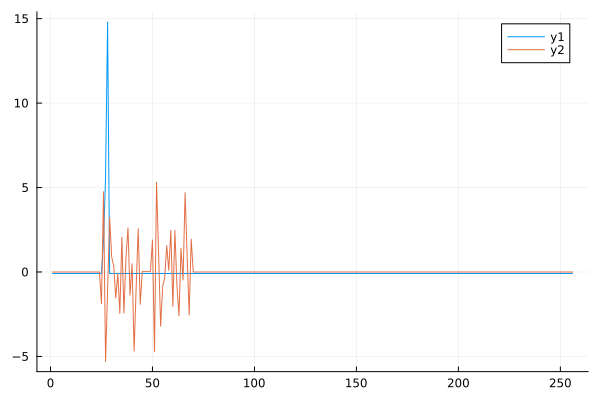

In [166]:

plot(cpu(d1x))
plot!(cpu(d1x0))

In [167]:
function g!(G, x)
    CUDA.allowscalar(true)
g1x = ForwardDiff.gradient(d1x->ideal_nuisance_func(d1x0, d1x), d1x) # compute gradient
CUDA.allowscalar(false)
copyto!(G, g1x)
end
function g(x)
    g=similar(x)
    g!(g, x)
    return g
end

g (generic function with 1 method)

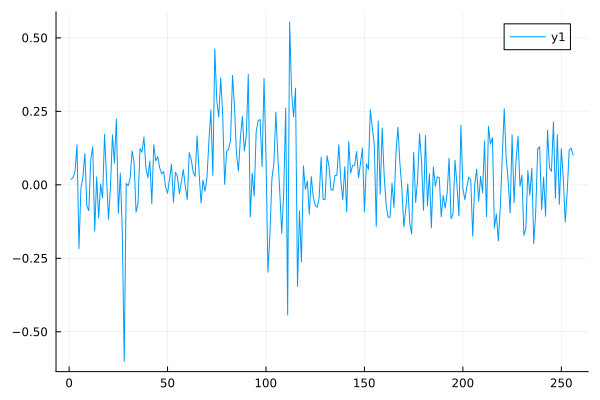

In [168]:
plot(cpu(g(d1x)))

In [169]:
using Optim

In [170]:
x=optimize(d1x->ideal_nuisance_func(d1x0, d1x), g, d1x, LBFGS(linesearch = Optim.BackTracking(order=2)), Optim.Options(g_tol = 1e-12,
                             iterations = 20,
                             show_trace = true); inplace=false)

Iter     Function value   Gradient norm 
     0     7.725798e+00     6.008638e-01


 * time: 1.4597408771514893


     1     5.452371e+00     6.008638e-01
 * time: 8.788313865661621


     2     5.076486e+00     6.008638e-01
 * time: 14.126044988632202


     3     4.739047e+00     6.008638e-01
 * time: 19.436376810073853


     4     4.155104e+00     6.008638e-01
 * time: 24.676739931106567


     5     3.981259e+00     6.008638e-01
 * time: 30.15064787864685


     6     3.651680e+00     6.008638e-01
 * time: 35.43347191810608


     7     3.545332e+00     6.008638e-01
 * time: 40.68653893470764


     8     3.542983e+00     6.008638e-01
 * time: 46.41188597679138


     9     3.542982e+00     6.008638e-01
 * time: 53.21051597595215


    10     3.542982e+00     6.008638e-01
 * time: 55.997503995895386


 * Status: success

 * Candidate solution
    Final objective value:     3.542982e+00

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 6.01e-01 ≰ 1.0e-12

 * Work counters
    Seconds run:   56  (vs limit Inf)
    Iterations:    10
    f(x) calls:    56
    ∇f(x) calls:   10


In [171]:
d1x=Optim.minimizer(x)

256-element CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}:
 -0.21966855
 -0.2658724
 -0.41454366
 -1.0490644
  1.4412457
 -0.010496283
 -0.2821079
 -0.8405247
  0.41889954
  0.5316918
  ⋮
 -1.2913893
  0.37919587
 -0.95704806
 -0.2543791
  0.8059214
  0.07633471
 -0.9245041
 -0.96790606
 -0.80436015

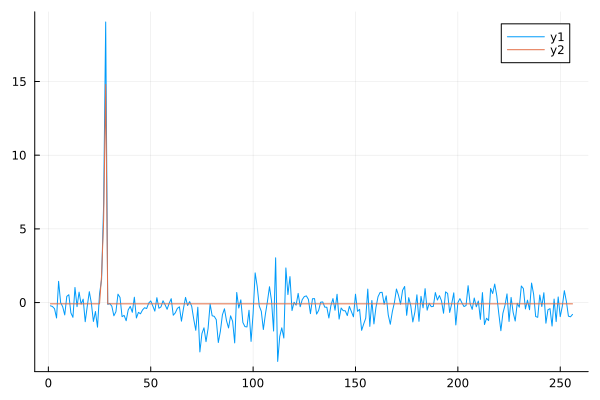

In [172]:
plot(cpu(d1x))
plot!(cpu(d1x_initial))